In [ ]:
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('  allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import time
import json
import os

import pyarrow.feather as pfeather
import matplotlib.pyplot as plt
from scipy import stats

CAPITAL_BOUNDARY = 150000
if not os.path.exists('models'):
    os.mkdir('models')

torch.manual_seed(3)
plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.rainbow(np.linspace(0, 1, 5)))

N = 3983
N_tiers = 13+1 # 0 is fallback


In [27]:
# As = torch.stack([torch.load('../input/am4-default/A-V4_3.pt', map_location='cuda') for _ in range(N_tiers)])

apdf = pd.read_csv('/kaggle/input/am4-default/airports.csv', delimiter=',', index_col='id')
tier_id_map = {
    6000: 1, 12000: 2, 18000: 3, 24000: 4, 30000: 5,
    36000: 6, 42000: 7, 48000: 8, 54000: 9, 60000: 10,
    189600: 11, 213300: 12, 237000: 13,
}
tiers = [0 for _ in range(N)]
for row in apdf.itertuples():
    aid = row.Index
    tiers[aid] = 9 if aid == 1763 else 11 if aid == 1762 else tier_id_map[row.hub_cost]
tiers = torch.tensor(tiers)#.cuda()


D = torch.load('../input/am4-default/D.pt')
avg_yD = torch.load('../input/am4-default/avg_yD.pt')

t = tiers.repeat_interleave(3, dim=0)
print(len(t))

# D = torch.load('../input/am4-default/D.pt', map_location='cuda')
# avg_yD = torch.load('../input/am4-default/avg_yD.pt', map_location='cuda')

# mask = ~torch.eye(N, dtype=bool).cuda()
# ys = D[mask].reshape(-1)

# mask = mask.view(-1)
# i = torch.arange(N, device='cuda').repeat(N)[mask]
# j = torch.arange(N, device='cuda').repeat_interleave(N)[mask]

# xs = torch.stack((i, j), dim=1) # [[i0, j0], ...]

# dataloader = DataLoader(
#     TensorDataset(xs, ys),
#     batch_size=batch_size,
#     shuffle=True
# )

11949


In [ ]:
class DemandModel(nn.Module):
    def __init__(self):
        super(DemandModel, self).__init__()
#         self.As = nn.Parameter(As)
        self.As = nn.Parameter(torch.zeros(N_tiers, N))
        self.Bs = nn.Parameter(torch.zeros(N_tiers, N))

    def forward(self, batch): # [[a, b], [c, d]], OD pairs
        iids, jids = batch.T # [a, c], [b, d]
        alliAs = self.As[tiers[iids]] # [a:A[...], c:A[...]]
        alljAs = self.As[tiers[jids]]
        alliBs = self.Bs[tiers[iids]]
        alljBs = self.Bs[tiers[jids]]
        
        i, j = iids.unsqueeze(1), jids.unsqueeze(1) # [[a], [c]], [[b], [d]]
        return (
            alliAs.gather(1, i) + alljAs.gather(1, j) + 
            alliBs.gather(1, i) + alljBs.gather(1, j)
        ).squeeze(1)

model = DemandModel().cuda()
# xs_test = torch.tensor([[1, 2], [4, 3], [3, 4]]).cuda()
# model(xs_test)
# oids, dids = batch.T
# # allAs = As[tiers[oids]] # torch.index_select(As, 0, tiers[oids])
# allAs = As[batch.T] # torch.index_select(As, 0, tiers[oids])
# i, j = oids.unsqueeze(1), dids.unsqueeze(1)
# oAs = allAs.gather(1, i)
# print(oAs)

In [ ]:
batch_size = N // 2
lr = 0.01
status_every = 200
epochs = 10
print(f'*** STARTING: batch size {batch_size}, lr {lr}, epochs {epochs}')

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

start = time.time()
losses = []
last_model = model
for e in range(epochs):
    total_loss = 0
    i = 0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
        
        if i > 0 and i % status_every == 0:
            l1 = .002 * sum([p.abs().sum() for p in model.parameters()])
            print(f'{i/len(dataloader)+e:.5f},{math.sqrt(loss)},{l1}')
        
        total_loss += loss.item()
        i += 1

    loss = math.sqrt(total_loss / len(dataloader))
#     print(f'{e:>5} | loss={loss}')

    torch.save(model.As, f'./models/As-V2_{e}.pt')
    torch.save(model.Bs, f'./models/Bs-V2_{e}.pt')
    losses.append(loss)
    last_model = model

print(f'*** DONE: {time.time() - start:.2f}s')

In [ ]:
plt.imshow(model.As.unsqueeze(1).cpu().detach().numpy(), cmap="hot", aspect="auto",interpolation='none')

In [ ]:
torch.save(model.As, 'xAs_V1.pt')
torch.save(model.Bs, 'xBs_V1.pt')

In [ ]:
hc

In [ ]:
# os.listdir('./models')
# import shutil
# shutil.copy('./models/A-V7_3.pt', './A-V7_3.pt')
# shutil.copy('./models/M-V7_3.pt', './M-V7_3.pt')

import shutil
shutil.rmtree('models')

for f in os.listdir('.'):
    if os.path.isfile(f):
        os.remove(f)

# ANALYSIS

In [2]:
apdf = pd.read_csv('/kaggle/input/am4-default/airports.csv', delimiter=',', index_col='id')
hc = {}
for row in apdf.itertuples():
    hc[row.Index] = row.hub_cost
hc[1762] = 213300
hc[1763] = 6000

routes_feather = pfeather.read_table('/kaggle/input/am4-default/routes').to_pandas()

D = np.zeros((3983, 3983), dtype=np.float32)
for oid, did, yd, jd, fd, d in routes_feather.itertuples(index=False):
    v = yd
    D[oid][did] = v
    D[did][oid] = v

0: 0.003316428494772439x+119.41009220997688, 0.9997504779305951
1: 0.0016345993983034799x+243.24879894634648, 0.9857984468597709


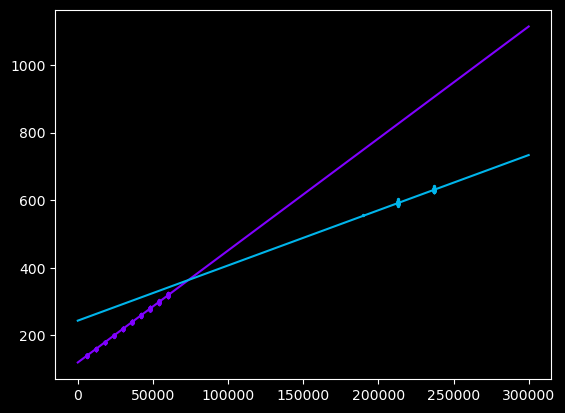

In [4]:
xs0, ys0 = [], []
xs1, ys1 = [], []
for i, h in hc.items():
    v = np.mean(D[i])
    if h < CAPITAL_BOUNDARY:
        xs0.append(h)
        ys0.append(v)
    else:
        xs1.append(h)
        ys1.append(v)

X = np.linspace(0, 300000)
m0, c0, R0, *_ = stats.linregress(xs0, ys0)
m1, c1, R1, *_ = stats.linregress(xs1, ys1)
print(f"0: {m0}x+{c0}, {R0}")
print(f"1: {m1}x+{c1}, {R1}")

plt.scatter(xs0, ys0, s=2)
plt.plot(X, m0*X + c0)
plt.scatter(xs1, ys1, s=2)
plt.plot(X, m1*X + c1)
# 0: 0.0033164284947724376x+119.41009220997694, 0.9997504779305951
# 1: 0.0016345993983034792x+243.24879894634665, 0.9857984468597706

In [14]:
tier_id_map = {
    6000: 1, 12000: 2, 18000: 3, 24000: 4, 30000: 5,
    36000: 6, 42000: 7, 48000: 8, 54000: 9, 60000: 10,
    189600: 11, 213300: 12, 237000: 13,
}

res = [[[] for _ in range(14)] for _ in range(14)]

tiers = []
for aid in hc.values():
    if aid not in tiers:
        tiers.append(aid)
    
tiers.sort()

xss = {}
yss = {}
for t in tiers:
    xss[t] = []
    yss[t] = []

for oid, did, yd, jd, fd, d in routes_feather.itertuples(index=False):
    hc0, hc1 = hc[oid], hc[did]
    hc0id, hc1id = tier_id_map[hc0], tier_id_map[hc1]
    res[hc0id][hc1id].append(yd)
    res[hc1id][hc0id].append(yd)
    for t in tiers:
        if hc0 == t or hc0 == t:
            xss[t].append(hc0 + hc1)
            yss[t].append(yd)


In [18]:
res1 = [[np.average(y) if len(y) > 0 else 0 for y in row] for row in res]
res1 = torch.tensor(res1)
torch.save(res1, 'avg_yD.pt')

12000
18000
24000
30000
36000
42000
48000
54000
60000
66000
195600
219300
243000
18000
24000
30000
36000
42000
48000
54000
60000
66000
72000
201600
225300
249000
24000
30000
36000
42000
48000
54000
60000
66000
72000
78000
207600
231300
255000
30000
36000
42000
48000
54000
60000
66000
72000
78000
84000
213600
237300
261000
36000
42000
48000
54000
60000
66000
72000
78000
84000
90000
219600
243300
267000
42000
48000
54000
60000
66000
72000
78000
84000
90000
96000
225600
249300
273000
48000
54000
60000
66000
72000
78000
84000
90000
96000
102000
231600
255300
279000
54000
60000
66000
72000
78000
84000
90000
96000
102000
108000
237600
261300
285000
60000
66000
72000
78000
84000
90000
96000
102000
108000
114000
243600
267300
291000
66000
72000
78000
84000
90000
96000
102000
108000
114000
120000
249600
273300
297000
219300
225300
231300
237300
243300
249300
255300
261300
267300
273300
402900
426600
450300
243000
249000
255000
261000
267000
273000
279000
285000
291000
297000
426600
450300
47400

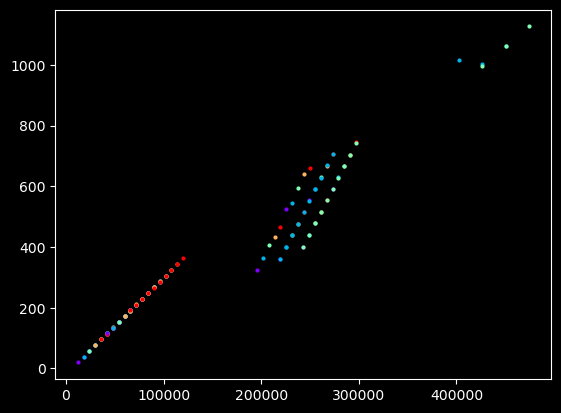

In [9]:
plt.clf()
for t in tiers:
    grp = {}
    for x, y in zip(xss[t], yss[t]):
        grp.setdefault(x, [])
        grp[x].append(y)
        
    xg, yg = [], []
#     ygmin, ygmax = [], []
    for k, v in sorted(grp.items(), key=lambda kv: kv[0]):
        xg.append(k)
        yg.append(np.mean(v))
#         ygmin.append(np.min(v))
#         ygmax.append(np.max(v))
#     plt.errorbar(xg, yg, yerr=(ygmin, ygmax), label=t)
    plt.scatter(xg, yg, label=t, s=4)
#     plt.scatter(xg, ygmin, alpha=.2, s=4)
#     plt.scatter(xg, ygmax, alpha=.2, s=4)

# plt.legend()
plt.show()

In [ ]:
i = 0

xsa, ysa = [], []
xs0, ys0 = [], []
xs1, ys1 = [], []
xs2, ys2 = [], []
xs3, ys3 = [], []
for oid, did, yd, jd, fd, d in routes_feather.itertuples(index=False):
    hc0, hc1 = hc[oid], hc[did]
    
    if hc0 + hc1 < 150000 or hc0 + hc1 > 350000:
        continue
    if hc0 == 189600 or hc1 == 189600:
        xs0.append(hc0 + hc1); ys0.append(yd)
    elif hc0 == 213300 or hc1 == 213300:
        xs1.append(hc0 + hc1); ys1.append(yd)
    elif hc1 == 237000 or hc1 == 237000:
        xs2.append(hc0 + hc1); ys2.append(yd)
    else:
        xs3.append(hc0 + hc1); ys3.append(yd)
    
    xsa.append(hc0 + hc1); ysa.append(yd)
    i += 1

plt.clf()
plt.scatter(xs0, ys0, color='lightcoral', alpha=.1, s=2)
plt.scatter(xs1, ys1, color='lightgreen', alpha=.01, s=2)
plt.scatter(xs2, ys2, color='lightblue', alpha=.01, s=2)
plt.scatter(xs3, ys3, color='white', alpha=.01,s=2)
plt.show()
##################################

m0, c0, R0, *_ = stats.linregress(xs0, ys0)
m1, c1, R1, *_ = stats.linregress(xs1, ys1)
m2, c2, R2, *_ = stats.linregress(xs2, ys2)
print(f"0: {m0}x+{c0}, {R0}")
print(f"1: {m1}x+{c1}, {R1}")
print(f"2: {m2}x+{c2}, {R2}")
print()
print(m0 / 189600, c0 / 189600)
print(m1 / 213300, c1 / 213300)
print(m2 / 237000, c2 / 237000)
##################################

cnts = {}
for x in xsa:
    cnts.setdefault(x, 0)
    cnts[x] += 1

cnts = [(k, v) for k, v in cnts.items()]
cnts.sort(key=lambda x: x[0])
cnts
##################################

cnts = {}
for aid, c in hc.items():
    cnts.setdefault(c, 0)
    cnts[c] += 1

cnts = [(k, v) for k, v in cnts.items()]
cnts.sort(key=lambda x: x[0])
cnts